In [1]:
%pylab inline
from glob import glob
from collections import OrderedDict
import sys
import simulation as sim
import metrics as mts
import healpy as hp
import fitsio
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Compare the Buzzard luminosity function with other LFs

The first thing you usually want to do when using this code is to define a simulation object. 'Simulation' is probably a bit of a misnomer at this point, as we use this object for real data as well. Maybe 'Universe' would be better...

Anyways, Simulation objects contain information about cosmology and geometry for now. They are the framework around which different types of catalogs are understood by the code.

In [9]:
bzd = sim.Simulation(0.3, 0.7, 0.7, 0.0, 2.0, 3*53.71)

We'll almost always want to use define a galaxy catalog as well. The goal of this piece of code is to hide the differences between various types of galaxy catalogs using different galaxy catalog classes which inherit from the same GalaxyCatalog class. That way, whenever we want to do something with a galaxy catalog, that action just needs to know about the GalaxyCatalog API.

In general a galaxy catalog object usually needs three pieces of information. The first piece of information are the metrics that we want to evaluate on the galaxy catalog. These metrics are functions which calculate summary statistics on the catalogs generally corresponding to observables that we care about.

In [10]:
bzdmetrics = [mts.LuminosityFunction(bzd)]

We'll start simple and just look at a luminosity function in one redshift bin. The luminosity function metric defaults to using a redshift bin of $0.0\le z < 0.2$.

The second piece of information we need is the location of the relevant files on disk, as well as the types of those files. This information is provided by a dictionary that I call a filestruct. See below for an example.

In [4]:
files = glob('/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.*.fit')
files[:5]

['/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.0.fit',
 '/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.4.fit',
 '/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.5.fit',
 '/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.13.fit',
 '/u/ki/jderose/desims/addgals/catalogs/Buzzard/Catalog_v1.1/truth/Buzzard_v1.1_truth.144.fit']

In [11]:
bfs = {}
bfs['truth'] = files[:5]

The key of the filestruct specifies the type of file and the value is a list of all the files of that type that we want to use. Here I have designated a number of 'truth' files, but the key could have been anything as long as it is refered to consistently.

In order for the BCC object to know where to find various pieces of information that it needs in the files we just definied, we should define something called a fieldmap. This is a dictionary whose keys are the fields that are required by the metrics we want to use. These fields are called mapkeys in the code. 

The values of a fieldmap are also dictionaries. This time, the keys are the names of the fields corresponding to mapkeys in a catalog file, and the values are lists telling us which types of files we can find the keys. In this case, the LuminosityFunction metric requires two mapkeys, luminosity and redshift. Thus we must define a fieldmap with these mapkeys as keys. The corresponding value of the luminosity key tells us that the luminosities are located in the 'AMAG' field of truth files. Likewise, redshifts are located in the 'Z' field of truth files.

In [12]:
fm = {'luminosity':OrderedDict([('AMAG',['truth'])]),
      'redshift':OrderedDict([('Z', ['truth'])])}

Now we have all of the information that our GalaxyCatalog object needs. This particular galaxy catalog that we are using now is a 'BCC' (Blind Cosmology Challege, archaic) catalog. Thus we set our simulations galaxy catalog using the function below.


In [15]:
bzd.setGalaxyCatalog('BCC', bfs, fieldmap=fm)
bzd.galaxycatalog.metrics = bzdmetrics

In [16]:
bzd.validate()

Now we can compare this to a the Bernardi 2013 (http://arxiv.org/abs/1304.7778) luminosity function as well as a double Schechter function plus a Gaussian tail at high luminosities.

In [21]:
bf = np.array(['/u/ki/jderose/ki23/amatch/bernardi-test/anc/LF_SerExpAll.dat'])
bern = sim.Simulation(0.286, 0.714, 0.7, 0.0, 2.0, 53.71)
bernLF = mts.TabulatedLuminosityFunction(bern,fname=bf)
bernLF.loadLuminosityFunction()

In [22]:
p0 = np.array([  1.50528627e-02,  -1.66000000e-01,   6.47466081e-03,  -1.52300000e+00,
  -2.00100000e+01,   2.0e-03,  -2.1500000e+01,   7.500000e-01])
dsgin = sim.Simulation(0.286, 0.714, 0.7, 0.0, 2.0, 53.71)
dsgLF = mts.AnalyticLuminosityFunction(dsgin)
dsgLF.calcNumberDensity(p0, form='doubleSchechterGaussian')

In [23]:
bzdLF = bzd.galaxycatalog.metrics[0]

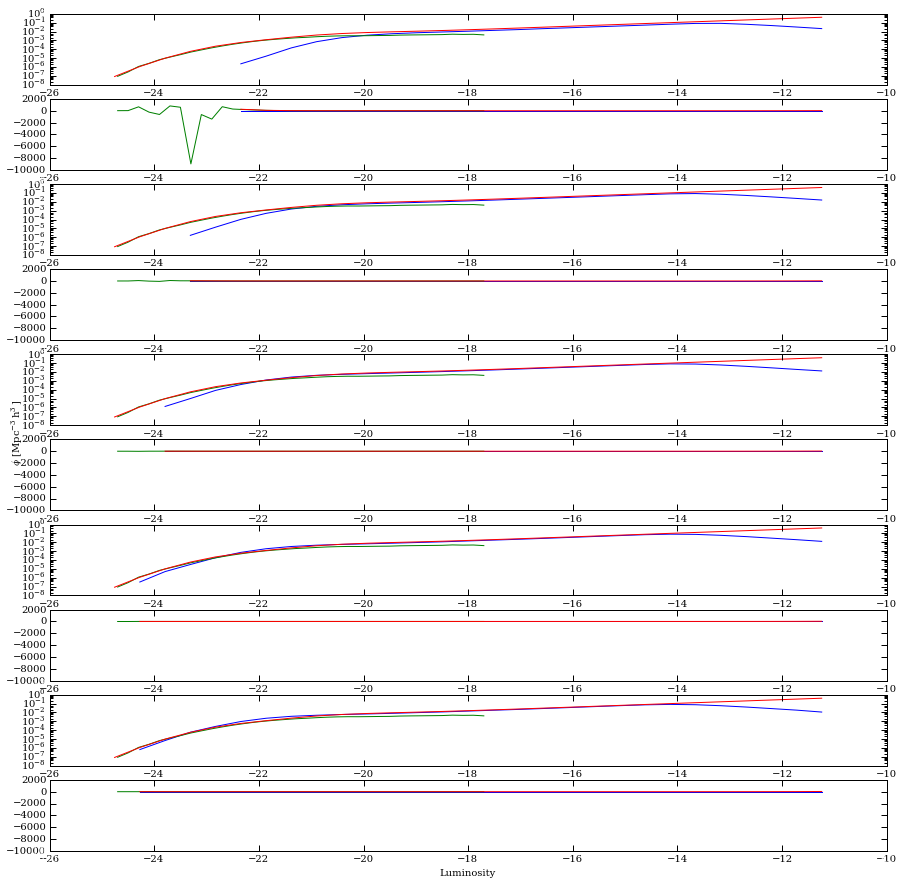

In [28]:
f, ax = bzdLF.compare([bernLF, dsgLF], fylim=[-1.0, 1.0])
f.set_figheight(15)
f.set_figwidth(15)